<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/trend-momentum-spot-analysis/update_2023/is_momo_of_momo_predictive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Is momo of momo predictive?

Here we take a proxy for short term momentum and calculate 40-day returns to the resulting momentum strategy. We investigate whether 40-day momentum strategy performance is predictive of the next 40-day's performance, and the next day's performance.

In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = FALSE, extra_libraries = c('lubridate', "glue", "tibbletime","roll","RcppRoll","Rcpp", "patchwork"), extra_dependencies = c('RcppParallel'))

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Using 2  CPUs for package installation

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




bit (4.0.4 -> 4.0.5) [CRAN]


Installing 1 packages: bit

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



openssl (2.0.6    -> 2.1.1   ) [CRAN]
curl    (5.0.2    -> 5.2.0   ) [CRAN]
gargle  (1.5.1    -> 1.5.2   ) [CRAN]
zip     (2.3.0    -> 2.3.1   ) [CRAN]
arrow   (13.0.0.1 -> 14.0.0.2) [CRAN]
── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpAJ4PVQ/remotes106458179a8/RWLab-rwRtools-88f4072/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘rwRtools_0.1.67.tar.gz’



In [2]:
# snippet: rw data auth v.0.1
rwlab_data_auth()

Authorization successful!

In [3]:
# load binance prices
prices <- rwRtools::crypto_get_binance_spot_1h()

ℹ Downloading binance_spot_1h.feather

✔ Saved binance_spot_1h.feather to binance/binance_spot_1h.feather  ( 879.5 Mb )





File successfully transferred


In [4]:
head(prices)

Ticker,Datetime,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
BTCUSDT,2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,202366.14,171,35.160503,150952.48
ETHUSDT,2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.668770,37684.80,129,80.563770,24193.44
BTCUSDT,2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,100304.82,102,21.448071,92608.28
ETHUSDT,2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.672460,114043.28,202,328.104280,99079.80
BTCUSDT,2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,31282.31,36,4.802861,20795.32
ETHUSDT,2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.866720,92034.44,182,259.286680,78525.95


Make a daily price series

In [5]:
# make a daily series of spot prices - requires some data wrangling
daily <- prices %>%
  mutate(Date = lubridate::as_date(Datetime)) %>%
  group_by(Ticker, Date) %>%
  arrange(Date) %>%
  summarise(
    open = first(Open),
    high = max(High),
    low = min(Low),
    close = last(Close),
    dollar_volume = sum(`Quote asset volume`)
  ) %>%
  ungroup() %>%
  arrange(Date, Ticker)

# remove LUNAUSDT from Friday 13 May 2022. Even though it continued to exist after this, there's no way you'd include it in your universe of tradable assets.
daily <- daily %>%
  filter(! (Ticker == "LUNAUSDT" & Date >= "2022-05-13"))

  daily %>% head

`summarise()` has grouped output by 'Ticker'. You can override using the
`.groups` argument.


Ticker,Date,open,high,low,close,dollar_volume
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BTCUSDT,2017-08-17,4261.48,4485.39,4200.74,4285.08,3454770.1
ETHUSDT,2017-08-17,301.13,312.18,298.00,302.00,2154655.3
BTCUSDT,2017-08-18,4285.08,4371.52,3938.77,4108.37,5086958.3
ETHUSDT,2017-08-18,302.00,311.79,283.94,293.96,2858946.5
BTCUSDT,2017-08-19,4108.37,4184.69,3850.00,4139.98,1549483.7
ETHUSDT,2017-08-19,293.31,299.90,278.00,290.91,620022.6


Make a sensible universe - remove stables, wrapped coins, leveraged tokens. Take top n by rolling 30-day dollar volume.

In [6]:
# ditch stables and wrapped/leveraged tokens and keep only the data we need

# list of stablecoins from defi llama
url <- "https://stablecoins.llama.fi/stablecoins?includePrices=true"
response <- httr::GET(url)

stables <- response %>%
  content(as = "text", encoding = "UTF-8") %>%
  jsonlite::fromJSON(flatten = TRUE) %>%
  pluck("peggedAssets") %>%
  pull(symbol)

stables <- glue::glue("{stables}USDT")

# duplicates and others to remove
to_remove <- glue::glue("{c('BTCD', 'HBTC', 'IBBTC', 'RBTC', 'SBTC3', 'WNXM', 'WBTC', 'BNBBULL', 'BNBBEAR', 'EOSBULL', 'EOSBEAR', 'ETHBULL', 'ETHBEAR', 'XRPBULL', 'XRPBEAR')}USDT")

# Remove stablecoins and others
daily <- daily %>%
  filter(!Ticker %in% c(stables, to_remove)) %>%
  # retain only the data we need
  select(Ticker, Date, close, dollar_volume) %>%
  # ditch USDT part of Ticker
  mutate(Ticker = str_replace(Ticker, "USDT$", ""))

head(daily)

Ticker,Date,close,dollar_volume
<chr>,<date>,<dbl>,<dbl>
BTC,2017-08-17,4285.08,3454770.1
ETH,2017-08-17,302.00,2154655.3
BTC,2017-08-18,4108.37,5086958.3
ETH,2017-08-18,293.96,2858946.5
BTC,2017-08-19,4139.98,1549483.7
ETH,2017-08-19,290.91,620022.6


In [7]:
# limit universe
trading_universe_size <- 50

universe <- daily %>%
  # just get the top n by trailing 30-day volume
  group_by(Ticker) %>%
  mutate(trail_volume = roll::roll_mean(dollar_volume, 30)) %>%
  na.omit() %>%
  group_by(Date) %>%
  mutate(
    volume_rank = row_number(-trail_volume),
    is_universe = volume_rank <= trading_universe_size
  )

head(universe)

Ticker,Date,close,dollar_volume,trail_volume,volume_rank,is_universe
<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
BTC,2017-09-15,3700.00,6588767,3421516,1,TRUE
ETH,2017-09-15,253.00,3319312,1838235,2,TRUE
BTC,2017-09-16,3714.95,4804878,3466520,1,TRUE
ETH,2017-09-16,249.31,2647152,1854651,2,TRUE
BTC,2017-09-17,3699.99,2466490,3379171,1,TRUE
ETH,2017-09-17,257.55,1149704,1797677,2,TRUE


In [8]:
# proxy short term time-series momentum
universe <- universe %>%
  group_by(Ticker) %>%
  arrange(Date) %>%
  mutate(
    # momentum as 10-day returns
    momo_10 = (close - lag(close, 10))/lag(close, 10),
    # momentum as 10-day zscore (longer sd lookback for stability)
    zscore_10 = (close - roll::roll_mean(close, 10))/roll::roll_sd(close, 40),  # longer lookback on the sd to smooth it out a bit
    fwd_return = (dplyr::lead(close, 1) - close)/close
  ) %>%
  na.omit()

head(universe)

Ticker,Date,close,dollar_volume,trail_volume,volume_rank,is_universe,momo_10,zscore_10,fwd_return
<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<dbl>
BTC,2017-10-24,5477.03,14564496,6025803,1,TRUE,-0.066943896,-0.34730769,0.0388823870
ETH,2017-10-24,297.38,4253110,2185442,2,TRUE,-0.130467836,-0.50364555,-0.0097182057
BTC,2017-10-25,5689.99,12544848,6351159,1,TRUE,-0.003502633,-0.08697344,0.0301898597
ETH,2017-10-25,294.49,2840747,2223281,2,TRUE,-0.128624689,-0.46190466,0.0007470542
BTC,2017-10-26,5861.77,11417127,6663023,1,TRUE,0.017664869,0.10803428,-0.0158552792
ETH,2017-10-26,294.71,2306446,2255759,2,TRUE,-0.120767326,-0.27350825,0.0054969292


Is the pnl of the momentum strategy (measured over a period like 4x longer than the momo lookback, say) autocorrelated?.

i.e. is an asset for which 10d momentum did badly/well over the last 40d more likely to do badly/well over the next?

Time Series Momentum Strategy: weight in proportion to zscore  

In [9]:
# since we're scaling weights, remove data before we have minimum constituents (avoid putting more into assets at the start of the analysis period)
start_date <- universe %>%
  group_by(Date, is_universe) %>%
  summarize(count = n(), .groups = "drop") %>%
  filter(count >= trading_universe_size) %>%
  head(1) %>%
  pull(Date)
print(start_date)

# calculate weights and strategy returns by asset, calculate 40-day mean strategy returns by asset
returns_df <- universe %>%
  filter(is_universe == TRUE) %>%
  filter(Date >= start_date) %>%
  # scale weights so they sum to 1 each day
  group_by(Date) %>%
  mutate(momo_weight = zscore_10/sum(abs(zscore_10))) %>%
  na.omit() %>%
  mutate(
    momo_returns = momo_weight * fwd_return,
    momo_log_returns = log(1 + momo_returns)
  ) %>%
  # momentum of momo strategy returns by ticker
  group_by(Ticker) %>%
  mutate(momo_of_momo = roll::roll_mean(momo_log_returns, 40)) %>%
  na.omit()

head(returns_df)

[1] "2020-05-04"


Ticker,Date,close,dollar_volume,trail_volume,volume_rank,is_universe,momo_10,zscore_10,fwd_return,momo_weight,momo_returns,momo_log_returns,momo_of_momo
<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ADA,2020-06-12,0.07948,25476804,34028492,4,TRUE,0.009654472,-0.3061427,-0.0052843483,-0.01091546,5.768107e-05,5.767941e-05,0.0002845605
ALGO,2020-06-12,0.23170,1646984,2699388,33,TRUE,-0.057363710,-0.2790786,0.0129477773,-0.00995049,-1.288367e-04,-1.288450e-04,-0.0001010277
ATOM,2020-06-12,2.86200,2130636,3405152,29,TRUE,0.036580949,-0.7585947,0.0038434661,-0.02704754,-1.039563e-04,-1.039617e-04,-0.0001482378
BAND,2020-06-12,1.29600,2724752,2682207,34,TRUE,-0.231772377,-0.9805709,0.0771604938,-0.03496206,-2.697690e-03,-2.701335e-03,-0.0003229215
BAT,2020-06-12,0.22950,4015352,3797850,27,TRUE,0.065954482,-0.4948116,0.0126361656,-0.01764241,-2.229324e-04,-2.229573e-04,-0.0004871175
BCH,2020-06-12,240.85000,15013892,27467012,5,TRUE,-0.039864461,-1.0313795,-0.0006643139,-0.03677363,2.442923e-05,2.442893e-05,-0.0003190498


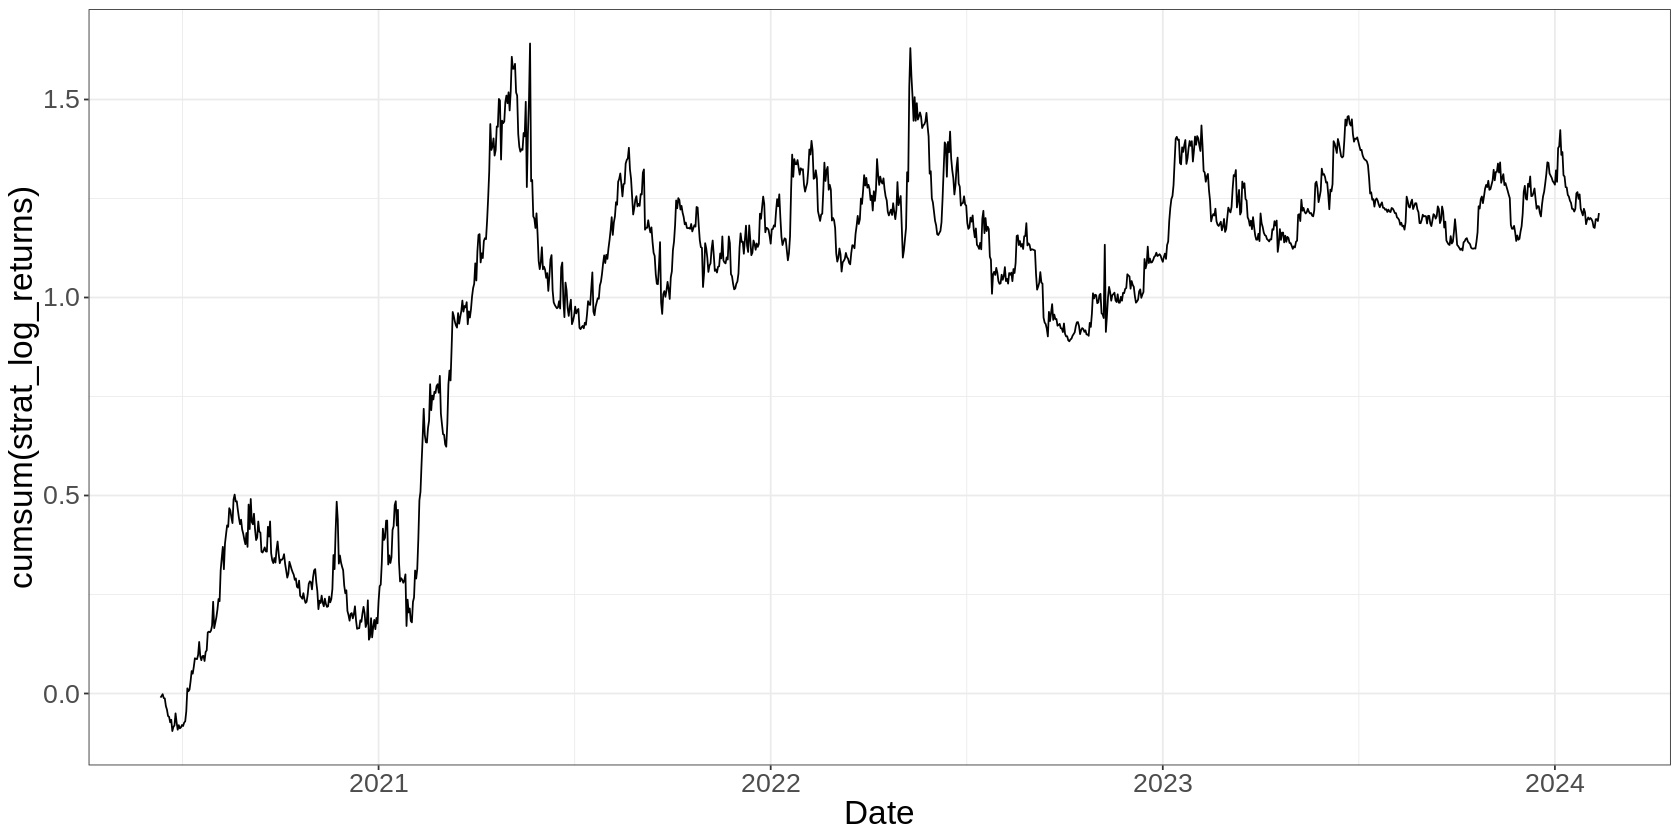

In [10]:
# strategy returns
returns_df %>%
  group_by(Date) %>%
  summarise(strat_returns = sum(momo_returns)) %>%
  mutate(strat_log_returns = log(1 + strat_returns)) %>%
  ggplot(aes(x = Date, y = cumsum(strat_log_returns))) + geom_line()

Is strategy performance autocorrelated?

`geom_smooth()` using formula = 'y ~ x'


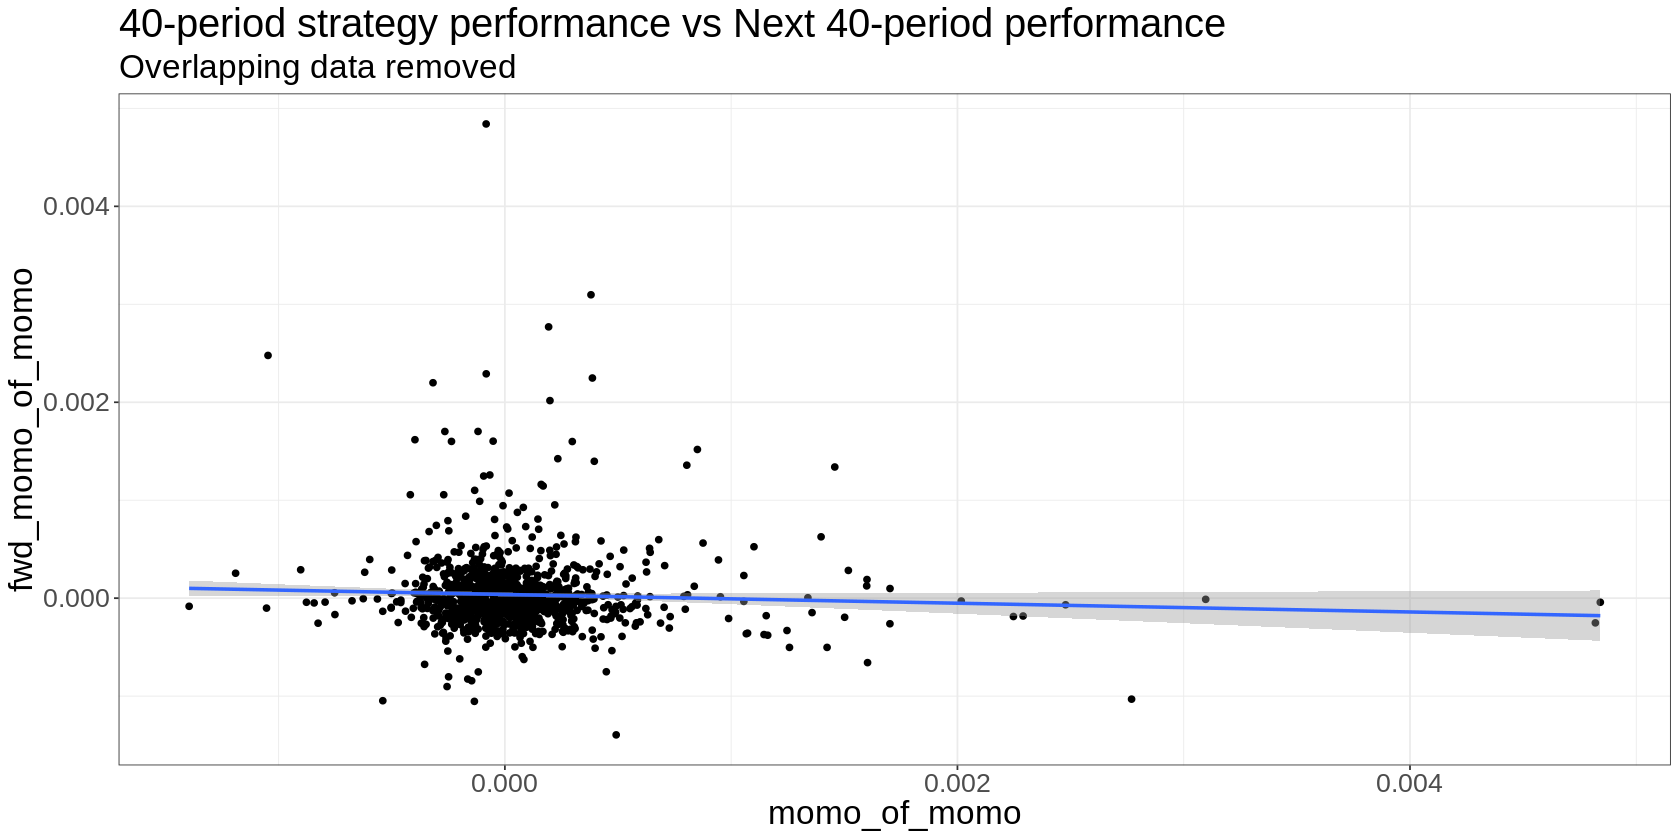

In [21]:
# need to consider overlapping data
analysis_df <- returns_df %>%
  group_by(Ticker) %>%
  # strategy performance in the next 40-day period
  mutate(fwd_momo_of_momo = lead(momo_of_momo, 40)) %>%
  # remove overlaps
  filter(row_number() %% 40 == 0) %>%
  na.omit() %>%
  ungroup()

# overall relationship considering all tickers
analysis_df %>%
  ggplot(aes(x = momo_of_momo, y = fwd_momo_of_momo)) +
  geom_point() +
  geom_smooth(method = "lm") +
  labs(
    title = "40-period strategy performance vs Next 40-period performance",
    subtitle = "Overlapping data removed"
  )

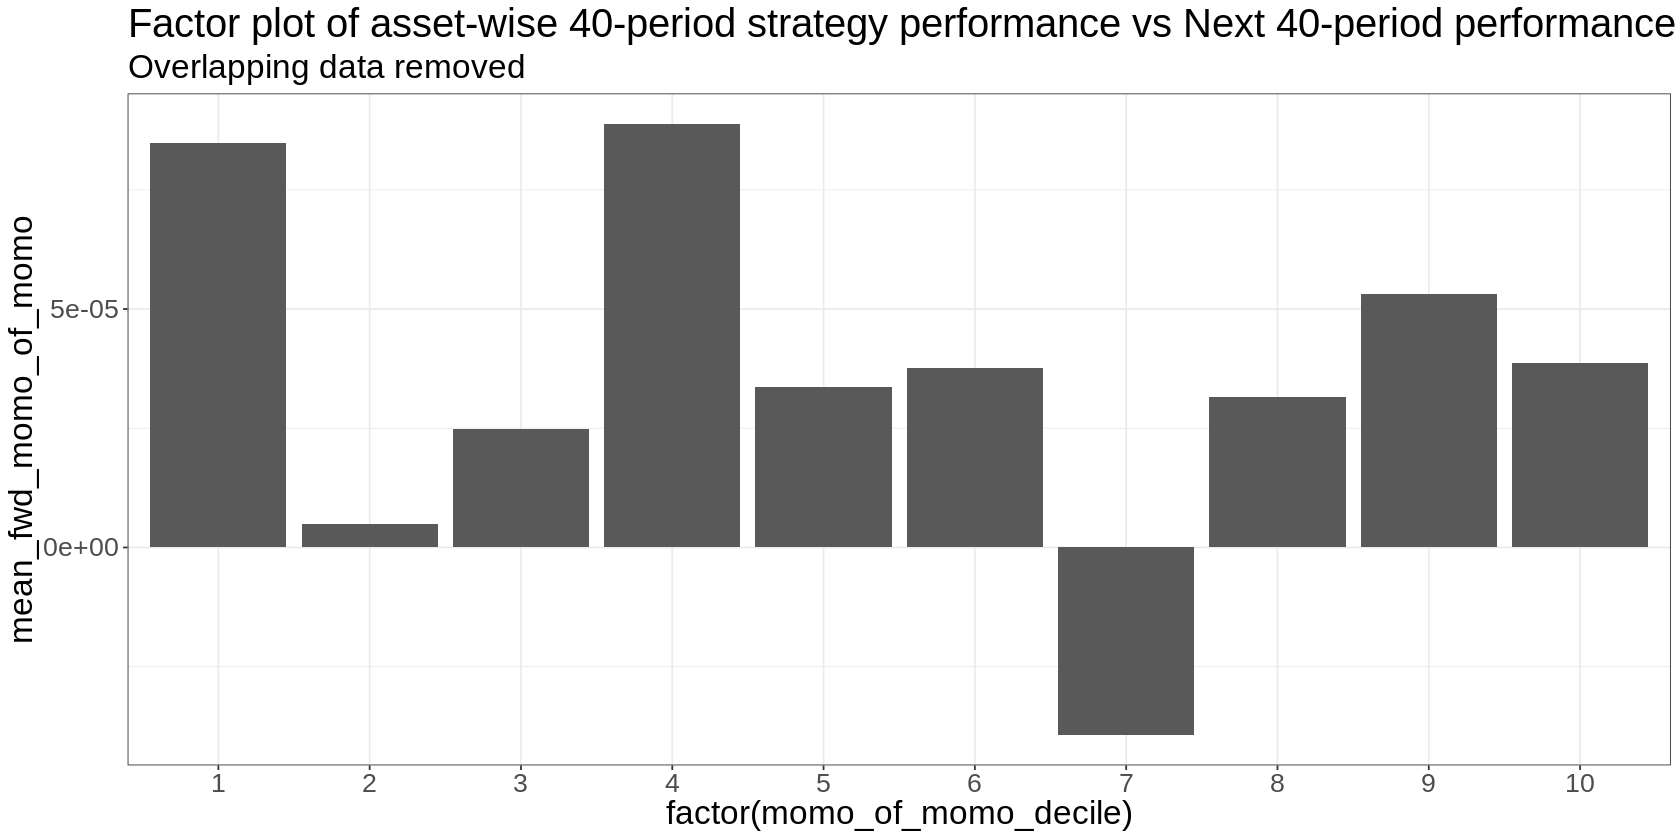

In [22]:
# factor plot across the whole time series for all assets - overlaps removed
analysis_df %>%
  mutate(momo_of_momo_decile = ntile(momo_of_momo, 10)) %>%
  group_by(momo_of_momo_decile) %>%
  summarise(mean_fwd_momo_of_momo = mean(fwd_momo_of_momo, na.rm = TRUE)) %>%
  ggplot(aes(x = factor(momo_of_momo_decile), y = mean_fwd_momo_of_momo)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Factor plot of asset-wise 40-period strategy performance vs Next 40-period performance",
    subtitle = "Overlapping data removed"
  )

Factor plot subject to some luck given we remove overlapping windows

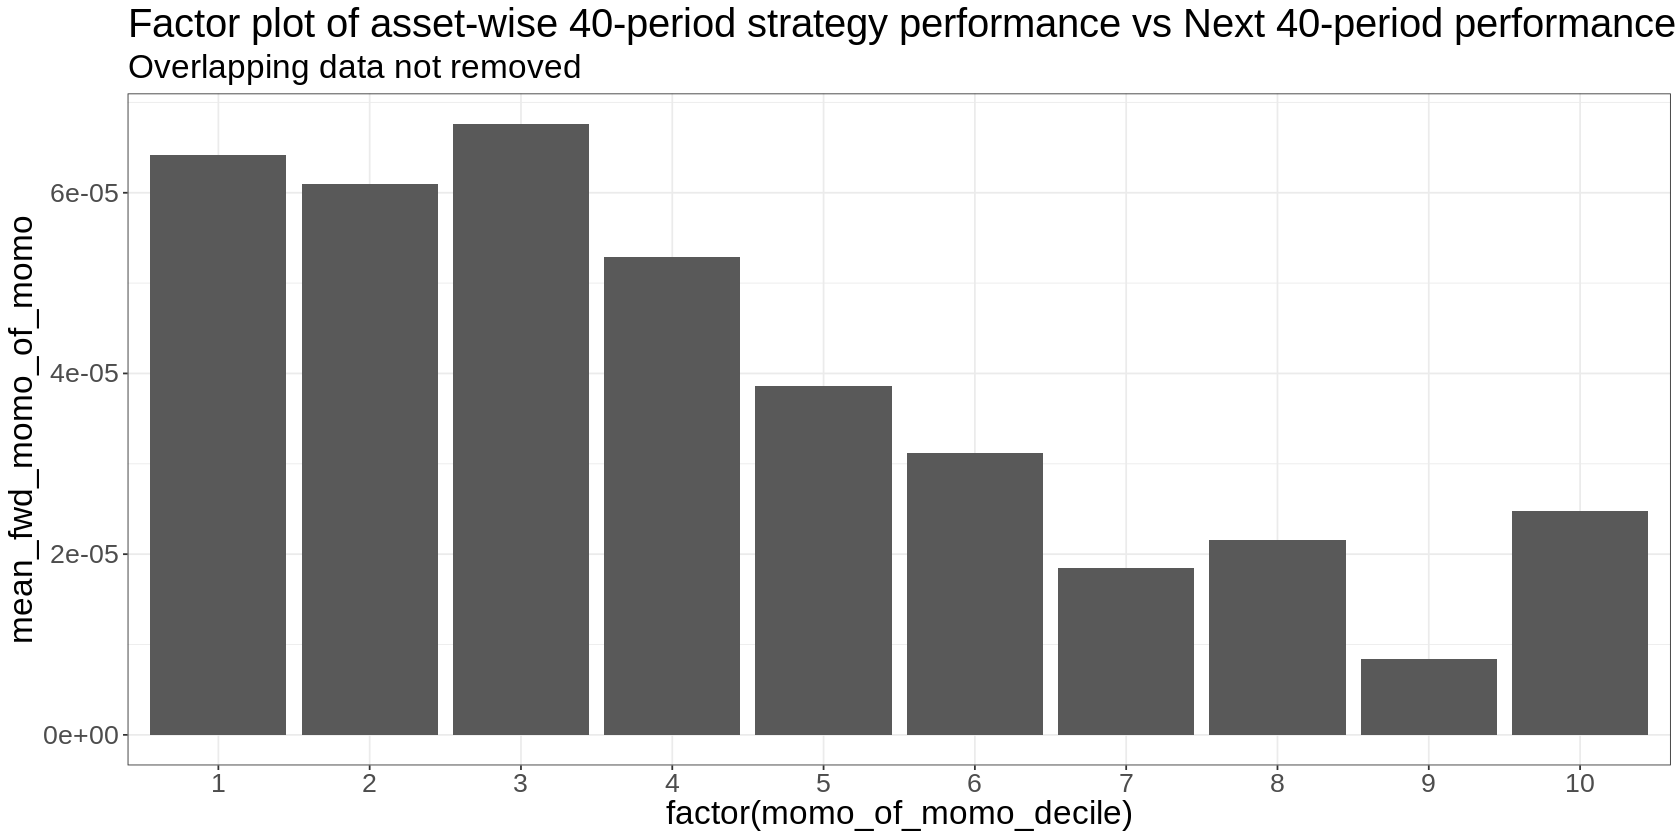

In [23]:
# don't remove overlaps this time
analysis_df <- returns_df %>%
  group_by(Ticker) %>%
  mutate(fwd_momo_of_momo = lead(momo_of_momo, 40)) %>%
  na.omit() %>%
  ungroup()

# factor plot of all the data
analysis_df %>%
  mutate(momo_of_momo_decile = ntile(momo_of_momo, 10)) %>%
  group_by(momo_of_momo_decile) %>%
  summarise(mean_fwd_momo_of_momo = mean(fwd_momo_of_momo, na.rm = TRUE)) %>%
  ggplot(aes(x = factor(momo_of_momo_decile), y = mean_fwd_momo_of_momo)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Factor plot of asset-wise 40-period strategy performance vs Next 40-period performance",
    subtitle = "Overlapping data not removed"
  )

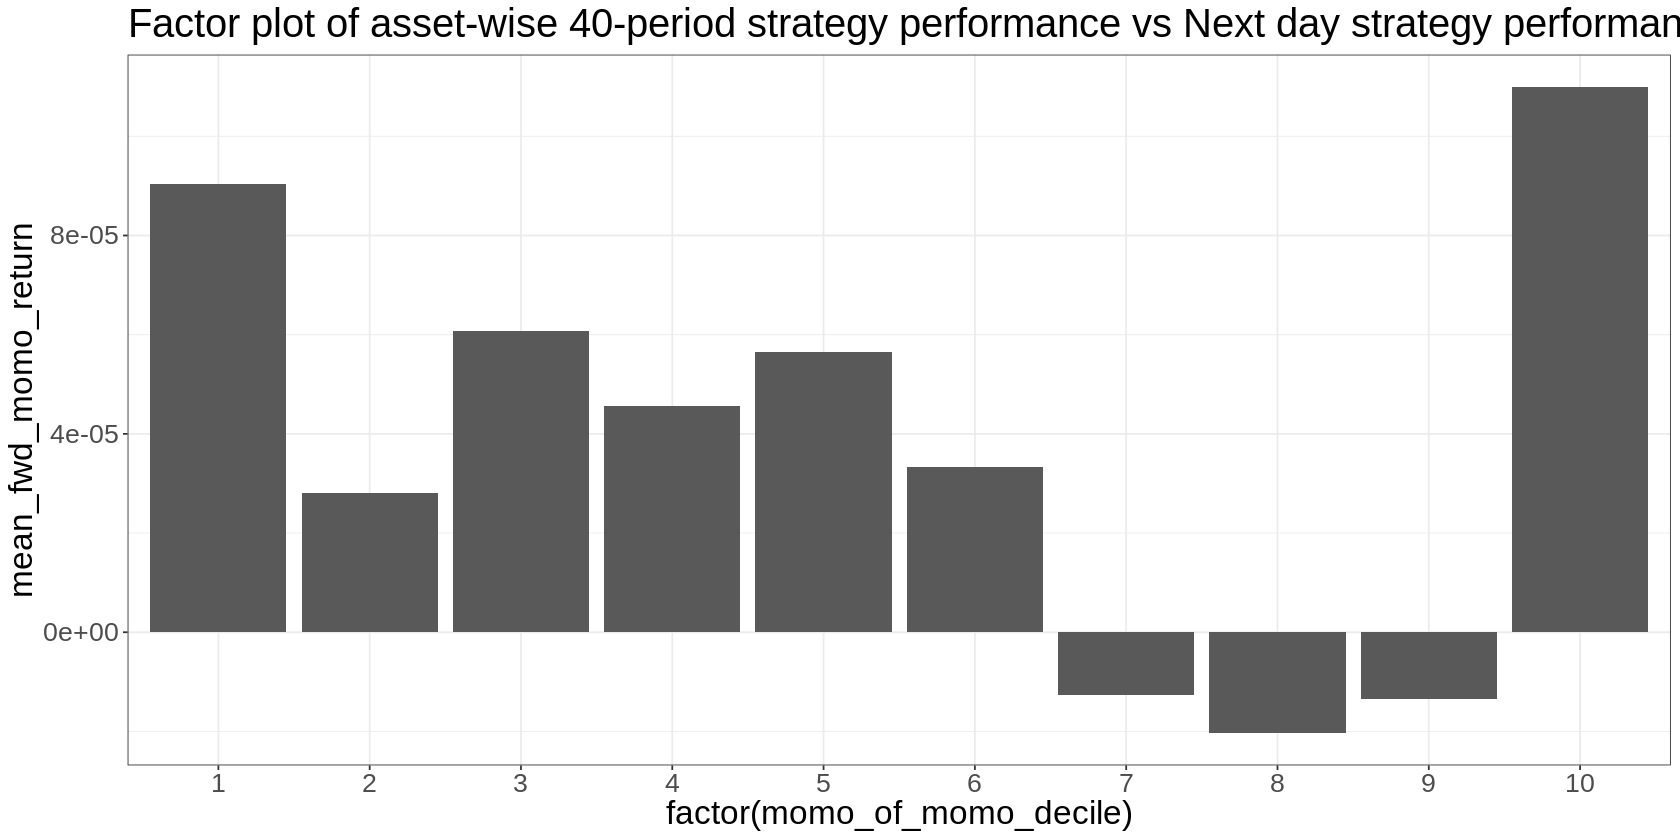

In [25]:
# how about vs next-day strategy returns
analysis_df <- returns_df %>%
  group_by(Ticker) %>%
  mutate(fwd_momo_return = lead(momo_returns, 1)) %>%
  na.omit() %>%
  ungroup()

# factor plot of all the data
analysis_df %>%
  mutate(momo_of_momo_decile = ntile(momo_of_momo, 10)) %>%
  group_by(momo_of_momo_decile) %>%
  summarise(mean_fwd_momo_return = mean(fwd_momo_return, na.rm = TRUE)) %>%
  ggplot(aes(x = factor(momo_of_momo_decile), y = mean_fwd_momo_return)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Factor plot of asset-wise 40-period strategy performance vs Next day strategy performance"
  )


Interesting. We see a similar general effect to the 40-day forward period, except the tenth decile more significantly bucks the general trend.

Look inside the tenth bucket by splitting into percentiles:

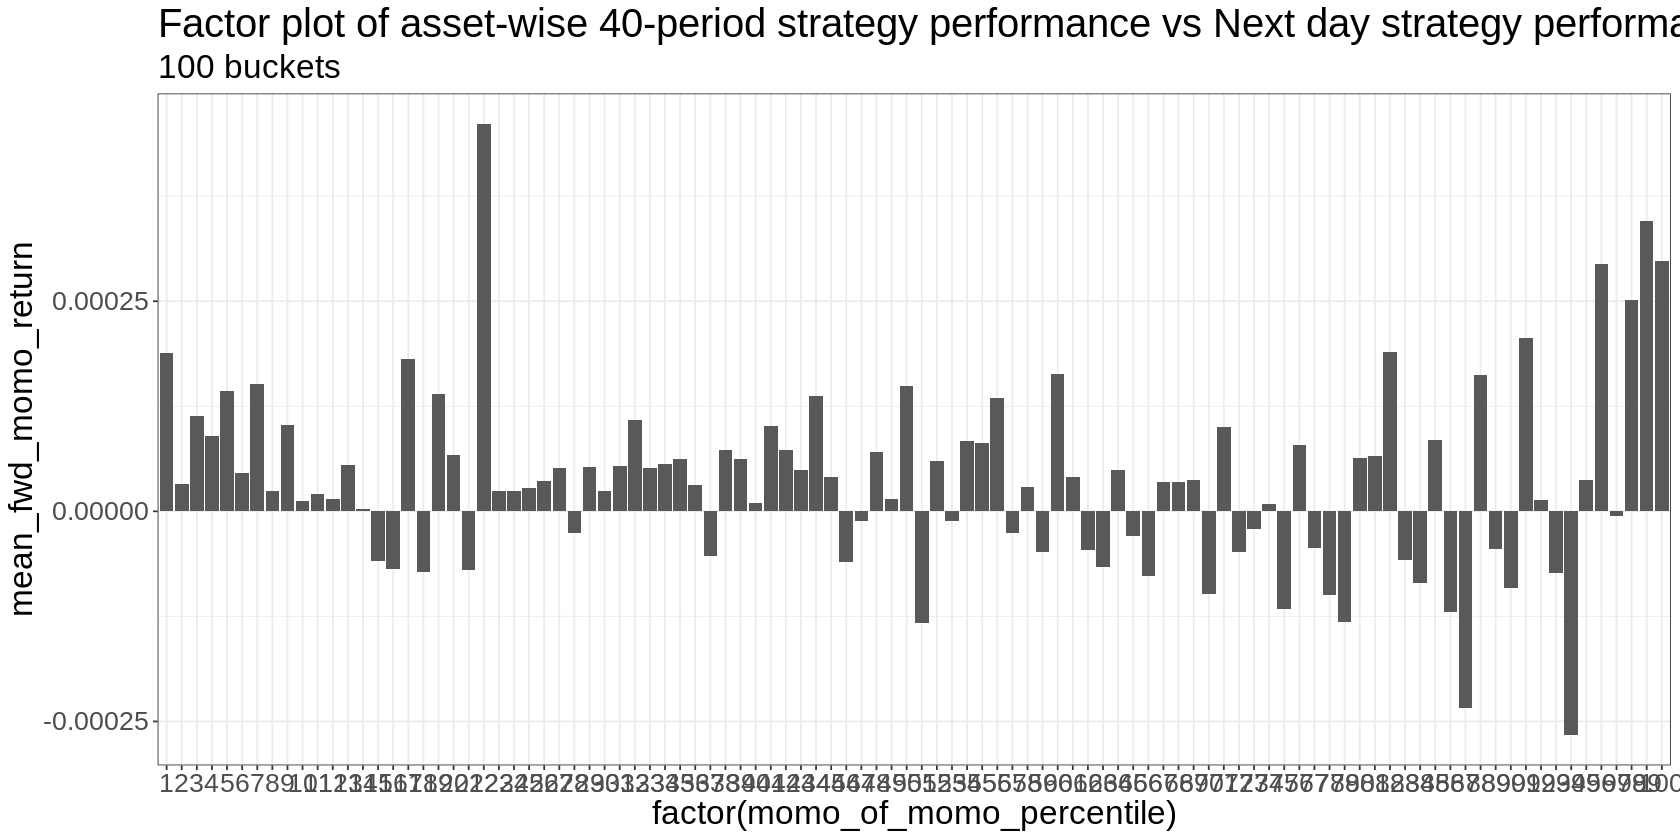

In [29]:
analysis_df <- returns_df %>%
  group_by(Ticker) %>%
  mutate(fwd_momo_return = lead(momo_returns, 1)) %>%
  na.omit() %>%
  ungroup()

# factor plot of all the data
analysis_df %>%
  mutate(momo_of_momo_percentile = ntile(momo_of_momo, 100)) %>%
  group_by(momo_of_momo_percentile) %>%
  summarise(mean_fwd_momo_return = mean(fwd_momo_return, na.rm = TRUE)) %>%
  ggplot(aes(x = factor(momo_of_momo_percentile), y = mean_fwd_momo_return)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Factor plot of asset-wise 40-period strategy performance vs Next day strategy performance",
    subtitle = "100 buckets"
  )


Generally an inverse relationship with 40-day momo performance. Except when 40-day momo performacne was in the ~95th percentile - in which case momo performance tended to continue.

Simple idea: scale up an asset's weight when the lagged sign of momo 40-day performance was negative, scale down when it's positive:*italicized text*

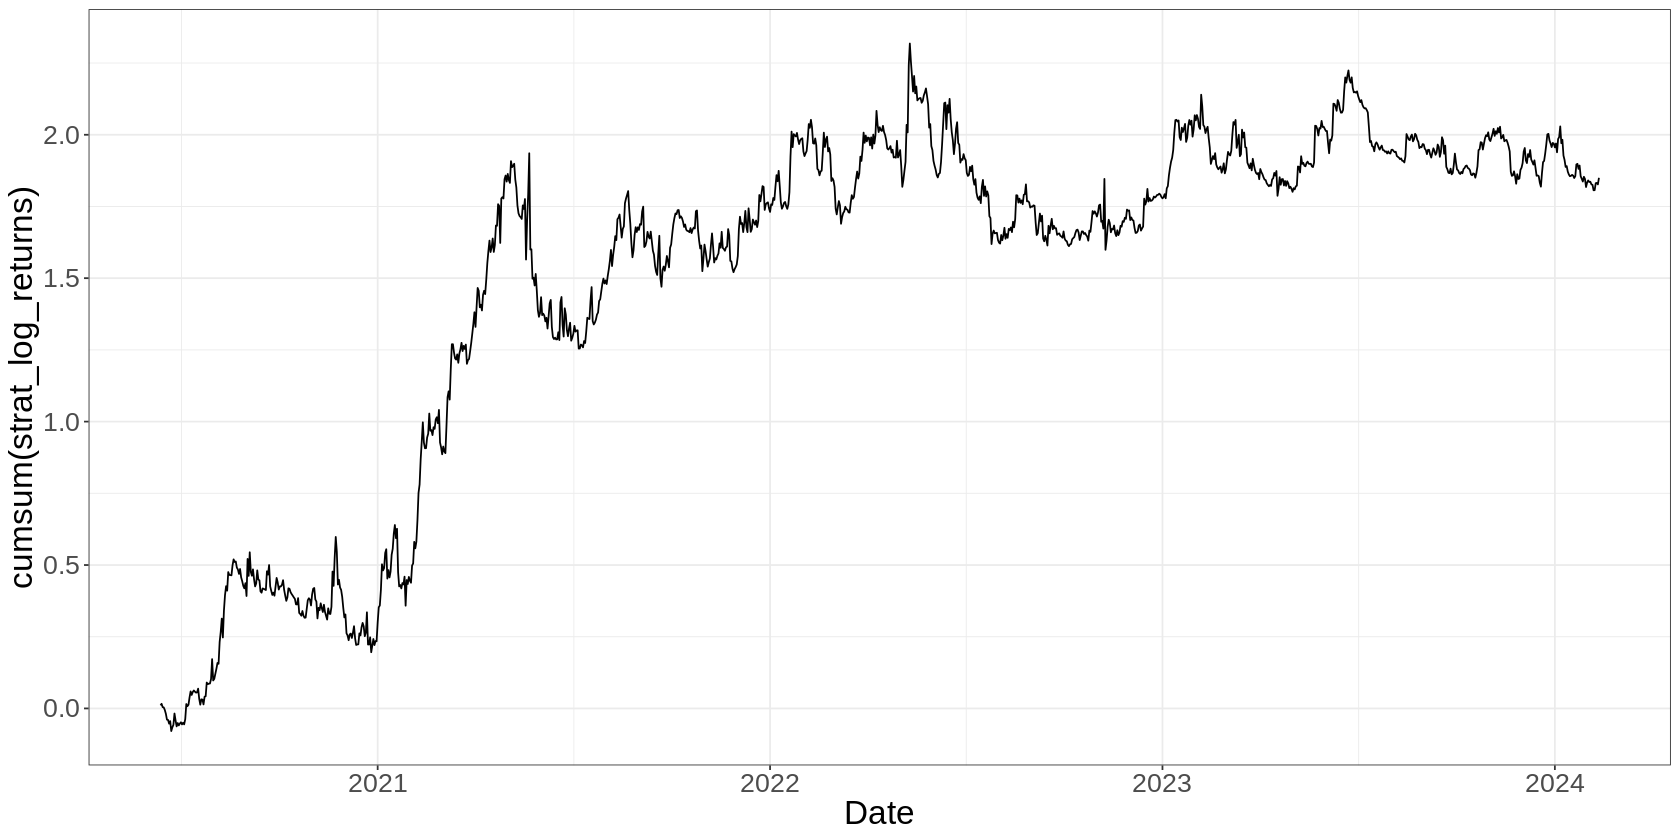

In [33]:
# Scale up when 40-day momo performance was negative
returns_df %>%
  group_by(Ticker) %>%
  mutate(momo_of_momo_sign = sign(momo_of_momo)) %>%
  mutate(lag_momo_of_momo_sign = lag(momo_of_momo_sign, 1)) %>%
  na.omit() %>%
  ungroup() %>%
  mutate(momo_of_momo_strat_weight = case_when(lag_momo_of_momo_sign < 0 ~ 2*momo_weight, TRUE ~ 0.5*momo_weight)) %>%
  group_by(Date) %>%
  mutate(scaled_momo_of_momo_strat_weight = momo_of_momo_strat_weight/sum(abs(momo_of_momo_strat_weight))) %>%
  ungroup() %>%
  mutate(strat_returns = scaled_momo_of_momo_strat_weight * fwd_return) %>%
  group_by(Date) %>%
  summarise(strat_returns = sum(strat_returns)) %>%
  mutate(strat_log_returns = log(1 + strat_returns)) %>%
  ggplot(aes(x = Date, y = cumsum(strat_log_returns))) + geom_line()

This next approach is a bit forward looking, but should be informative.

Scale by the inverse of lagged momo of momo decile - means we scale by a positive number that is bigger when momo of momo was smaller.

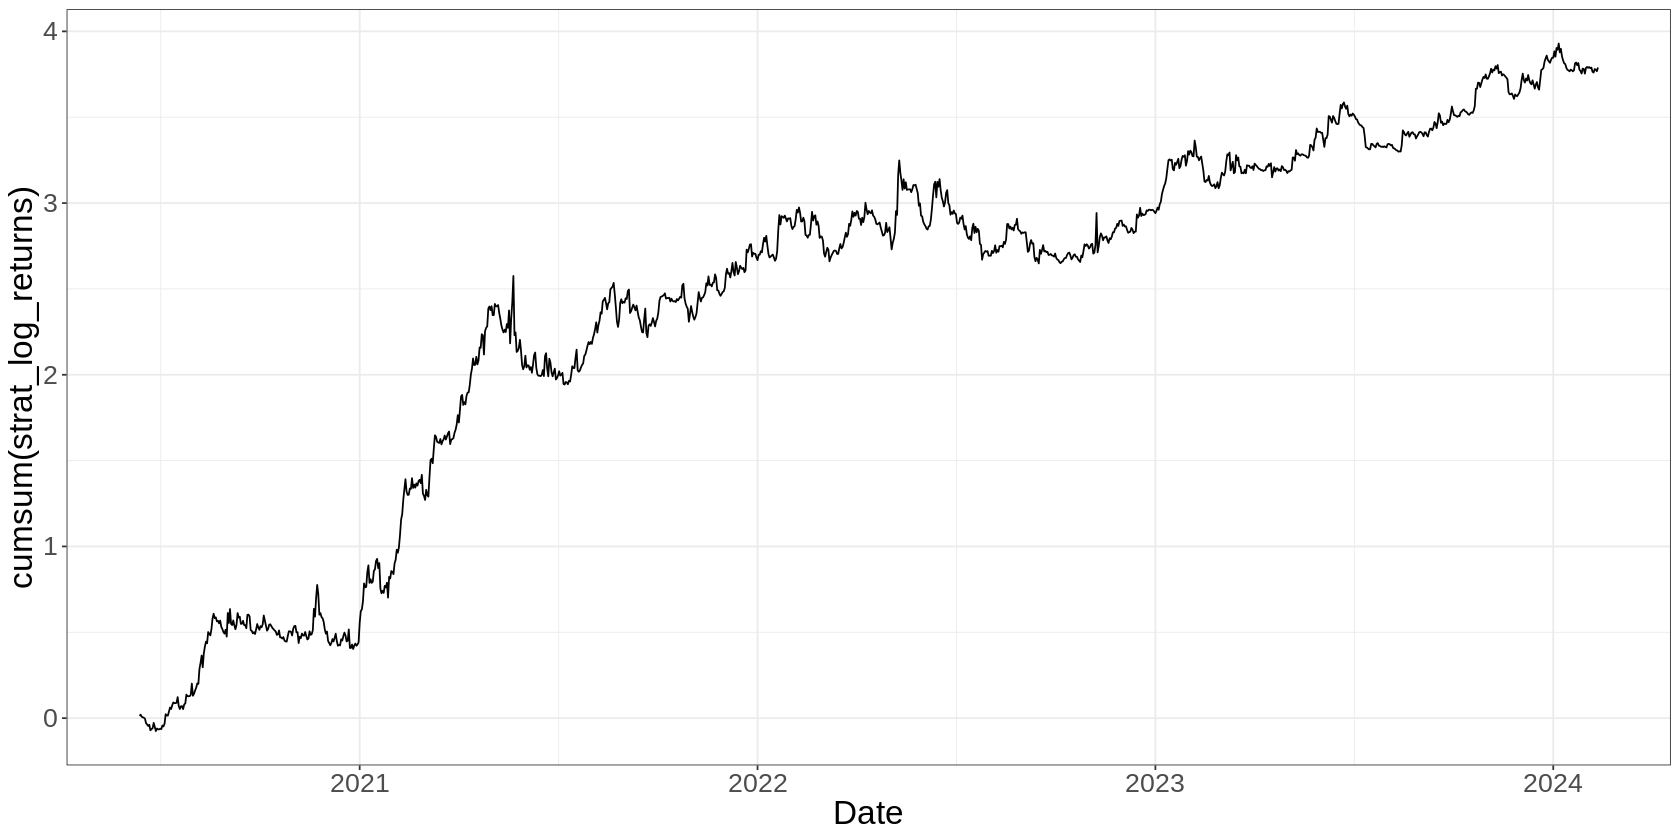

In [34]:
# scale weights by yesterday's 40-period momo returns
returns_df %>%
  group_by(Ticker) %>%
  # scale by inverse of lagged momo of momo decile - bit forward looking, but means we scale by a positive number that is bigger when momo of momo was smaller
  mutate(momo_of_momo_decile = ntile(momo_of_momo, 10)) %>%
  mutate(lag_momo_of_momo = lag(momo_of_momo_decile, 1)) %>%
  na.omit() %>%
  ungroup() %>%
  mutate(momo_of_momo_strat_weight = 1./lag_momo_of_momo * momo_weight) %>%
  group_by(Date) %>%
  mutate(scaled_momo_of_momo_strat_weight = momo_of_momo_strat_weight/sum(abs(momo_of_momo_strat_weight))) %>%
  ungroup() %>%
  mutate(strat_returns = scaled_momo_of_momo_strat_weight * fwd_return) %>%
  group_by(Date) %>%
  summarise(strat_returns = sum(strat_returns)) %>%
  mutate(strat_log_returns = log(1 + strat_returns)) %>%
  ggplot(aes(x = Date, y = cumsum(strat_log_returns))) + geom_line()

Is this effect more pronounced if we look at a better universe?

In [92]:
# limit universe
trading_universe_size <- 10

universe <- daily %>%
  # just get the bottom n by trailing 30-day volume
  group_by(Ticker) %>%
  mutate(trail_volume = roll::roll_mean(dollar_volume, 30)) %>%
  na.omit() %>%
  group_by(Date) %>%
  mutate(
    num_assets = n(),
    volume_rank = row_number(-trail_volume),
    is_universe = volume_rank <= trading_universe_size
  )

tail(universe)

Ticker,Date,close,dollar_volume,trail_volume,num_assets,volume_rank,is_universe
<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<int>,<lgl>
YFI,2024-02-12,7471.0000,1421166.7,2083011,355,217,FALSE
YGG,2024-02-12,0.4606,3236822.9,6747873,355,109,FALSE
ZEC,2024-02-12,20.4600,1523516.1,2726533,355,191,FALSE
ZEN,2024-02-12,7.8300,2478886.5,2441755,355,204,FALSE
ZIL,2024-02-12,0.0212,1621811.8,3096869,355,181,FALSE
ZRX,2024-02-12,0.3212,975800.6,3947039,355,148,FALSE


In [93]:
# proxy short term time-series momentum
universe <- universe %>%
  group_by(Ticker) %>%
  arrange(Date) %>%
  mutate(
    # momentum as 10-day returns
    momo_10 = (close - lag(close, 10))/lag(close, 10),
    # momentum as 10-day zscore (longer sd lookback for stability)
    zscore_10 = (close - roll::roll_mean(close, 10))/roll::roll_sd(close, 40),  # longer lookback on the sd to smooth it out a bit
    fwd_return = (dplyr::lead(close, 1) - close)/close
  ) %>%
  na.omit()

head(universe)

Ticker,Date,close,dollar_volume,trail_volume,num_assets,volume_rank,is_universe,momo_10,zscore_10,fwd_return
<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<int>,<lgl>,<dbl>,<dbl>,<dbl>
BTC,2017-10-24,5477.03,14564496,6025803,2,1,TRUE,-0.066943896,-0.34730769,0.0388823870
ETH,2017-10-24,297.38,4253110,2185442,2,2,TRUE,-0.130467836,-0.50364555,-0.0097182057
BTC,2017-10-25,5689.99,12544848,6351159,2,1,TRUE,-0.003502633,-0.08697344,0.0301898597
ETH,2017-10-25,294.49,2840747,2223281,2,2,TRUE,-0.128624689,-0.46190466,0.0007470542
BTC,2017-10-26,5861.77,11417127,6663023,2,1,TRUE,0.017664869,0.10803428,-0.0158552792
ETH,2017-10-26,294.71,2306446,2255759,2,2,TRUE,-0.120767326,-0.27350825,0.0054969292


Is the pnl of the momentum strategy (measured over a period like 4x longer than the momo lookback, say) autocorrelated?.

i.e. is an asset for which 10d momentum did badly/well over the last 40d more likely to do badly/well over the next?

Time Series Momentum Strategy: weight in proportion to zscore  

In [94]:
# since we're scaling weights, remove data before we have minimum constituents (avoid putting more into assets at the start of the analysis period)
start_date <- universe %>%
  group_by(Date, is_universe) %>%
  summarize(count = n(), .groups = "drop") %>%
  filter(count >= trading_universe_size) %>%
  head(1) %>%
  pull(Date)
print(start_date)

# calculate weights and strategy returns by asset, calculate 40-day mean strategy returns by asset
returns_df <- universe %>%
  filter(is_universe == TRUE) %>%
  filter(Date >= start_date) %>%
  # scale weights so they sum to 1 each day
  group_by(Date) %>%
  mutate(momo_weight = zscore_10/sum(abs(zscore_10))) %>%
  na.omit() %>%
  mutate(
    momo_returns = momo_weight * fwd_return,
    momo_log_returns = log(1 + momo_returns)
  ) %>%
  # momentum of momo strategy returns by ticker
  group_by(Ticker) %>%
  mutate(momo_of_momo = roll::roll_mean(momo_log_returns, 40)) %>%
  na.omit()

head(returns_df)

[1] "2018-08-19"


Ticker,Date,close,dollar_volume,trail_volume,num_assets,volume_rank,is_universe,momo_10,zscore_10,fwd_return,momo_weight,momo_returns,momo_log_returns,momo_of_momo
<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BCC,2018-09-27,566.62000,81258330,25037781,18,5,TRUE,0.35785665,1.48427568,-0.048198087,0.36188965,-0.0174423890,-0.0175962998,-0.0007973908
BTC,2018-09-27,6689.13000,216914853,250191903,18,1,TRUE,0.07048517,0.41055444,-0.008155022,0.10009960,-0.0008163144,-0.0008166478,-0.0002941353
EOS,2018-09-27,5.82530,74964578,69869827,18,3,TRUE,0.20362412,0.27523235,-0.011862050,0.06710596,-0.0007960142,-0.0007963312,-0.0011739333
ETC,2018-09-27,11.44790,13088303,16141500,18,9,TRUE,0.11360895,0.27389819,-0.017452983,0.06678067,-0.0011655218,-0.0011662016,-0.0011891019
ETH,2018-09-27,229.13000,128104933,107361445,18,2,TRUE,0.16807708,0.06645895,-0.031816000,0.01620373,-0.0005155379,-0.0005156709,-0.0006266936
XRP,2018-09-27,0.54305,103926812,60389793,18,4,TRUE,1.00683666,0.58579696,-0.005156063,0.14282647,-0.0007364223,-0.0007366936,0.0064892250


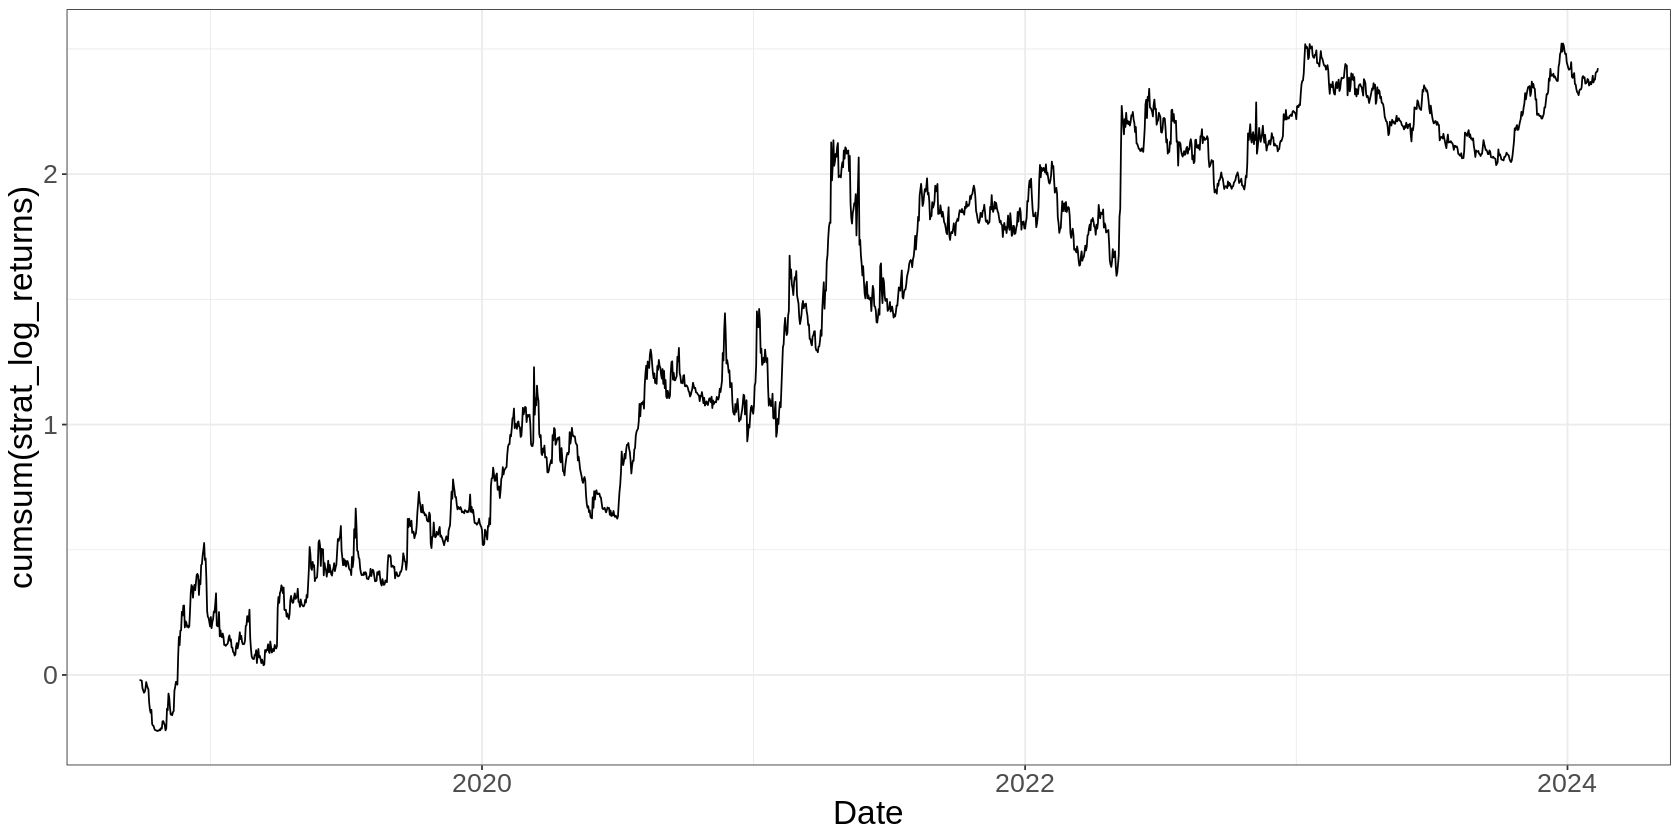

In [95]:
# strategy returns
returns_df %>%
  group_by(Date) %>%
  summarise(strat_returns = sum(momo_returns)) %>%
  mutate(strat_log_returns = log(1 + strat_returns)) %>%
  ggplot(aes(x = Date, y = cumsum(strat_log_returns))) + geom_line()

Is strategy performance autocorrelated?

`geom_smooth()` using formula = 'y ~ x'


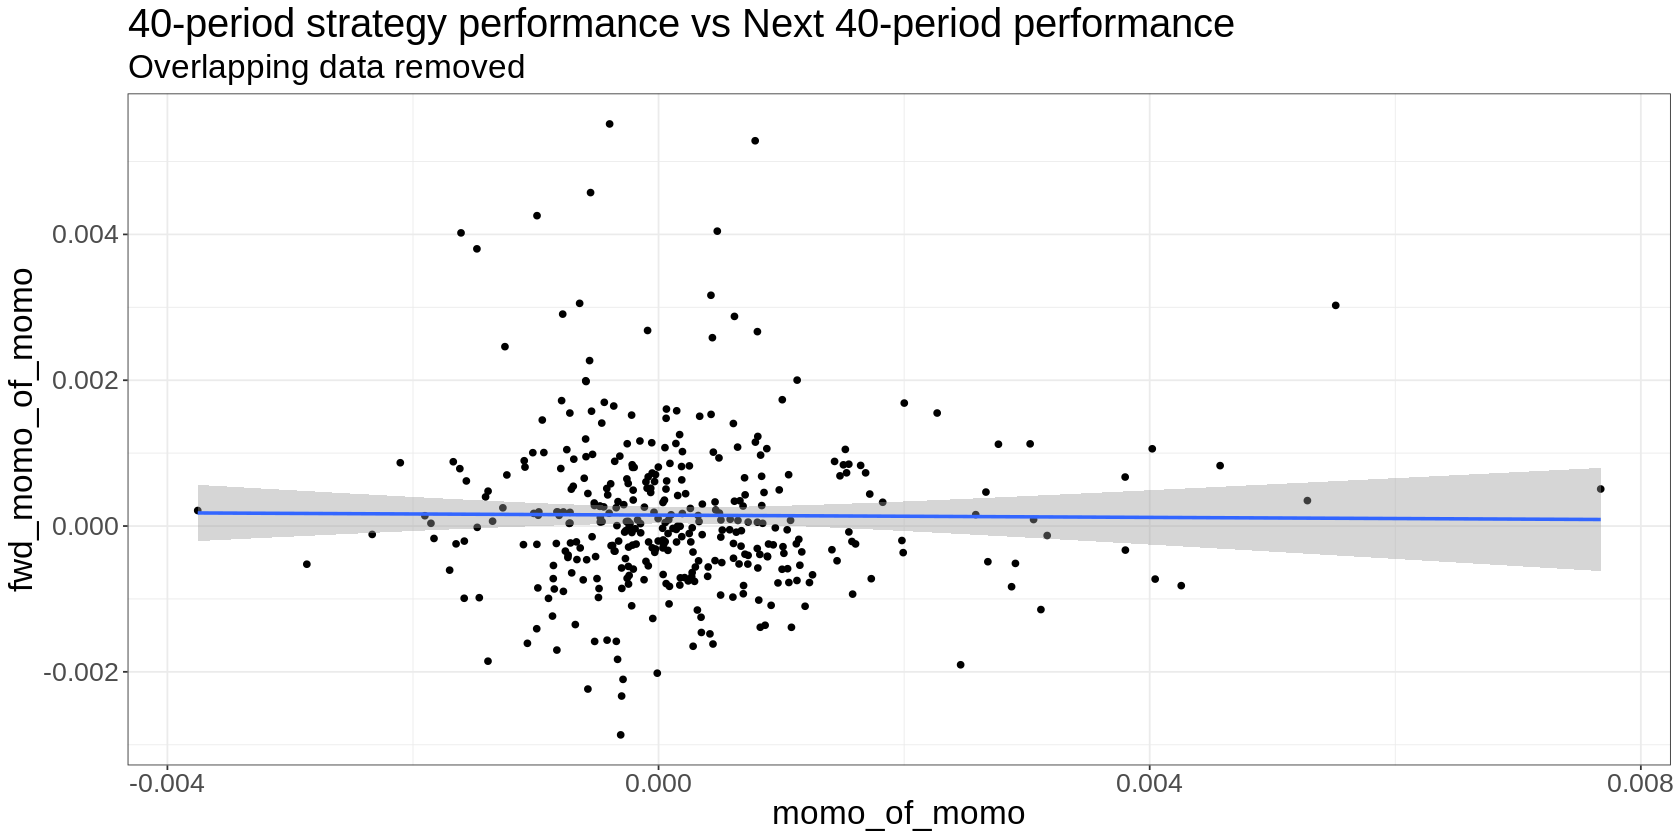

In [96]:
# need to consider overlapping data
analysis_df <- returns_df %>%
  group_by(Ticker) %>%
  # strategy performance in the next 40-day period
  mutate(fwd_momo_of_momo = lead(momo_of_momo, 40)) %>%
  # remove overlaps
  filter(row_number() %% 40 == 0) %>%
  na.omit() %>%
  ungroup()

# overall relationship considering all tickers
analysis_df %>%
  ggplot(aes(x = momo_of_momo, y = fwd_momo_of_momo)) +
  geom_point() +
  geom_smooth(method = "lm") +
  labs(
    title = "40-period strategy performance vs Next 40-period performance",
    subtitle = "Overlapping data removed"
  )

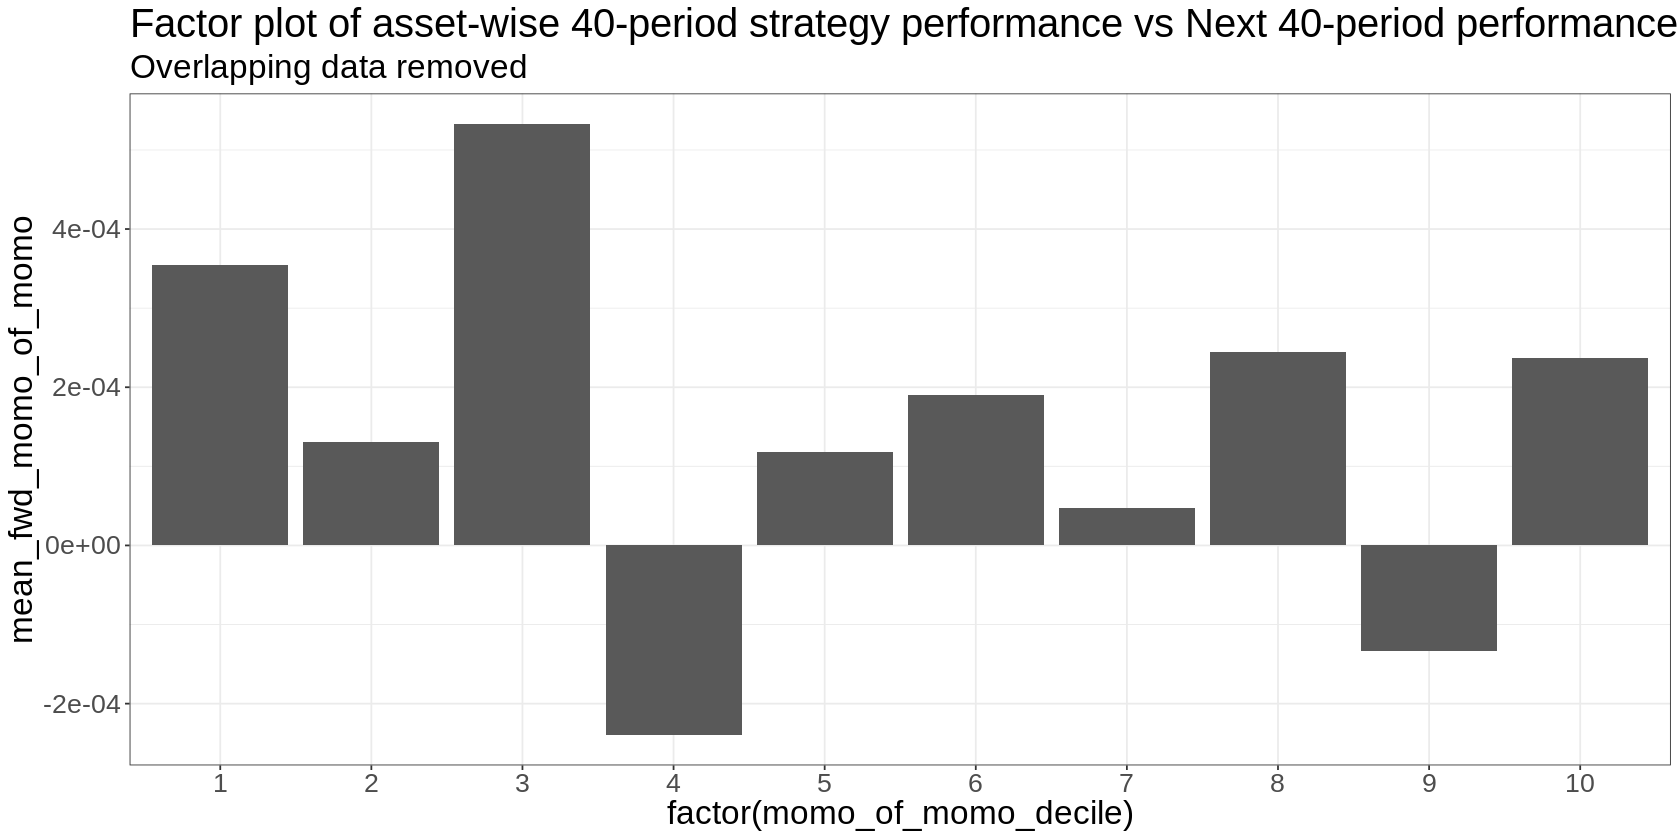

In [97]:
# factor plot across the whole time series for all assets - overlaps removed
analysis_df %>%
  mutate(momo_of_momo_decile = ntile(momo_of_momo, 10)) %>%
  group_by(momo_of_momo_decile) %>%
  summarise(mean_fwd_momo_of_momo = mean(fwd_momo_of_momo, na.rm = TRUE)) %>%
  ggplot(aes(x = factor(momo_of_momo_decile), y = mean_fwd_momo_of_momo)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Factor plot of asset-wise 40-period strategy performance vs Next 40-period performance",
    subtitle = "Overlapping data removed"
  )

Factor plot subject to some luck given we remove overlapping windows

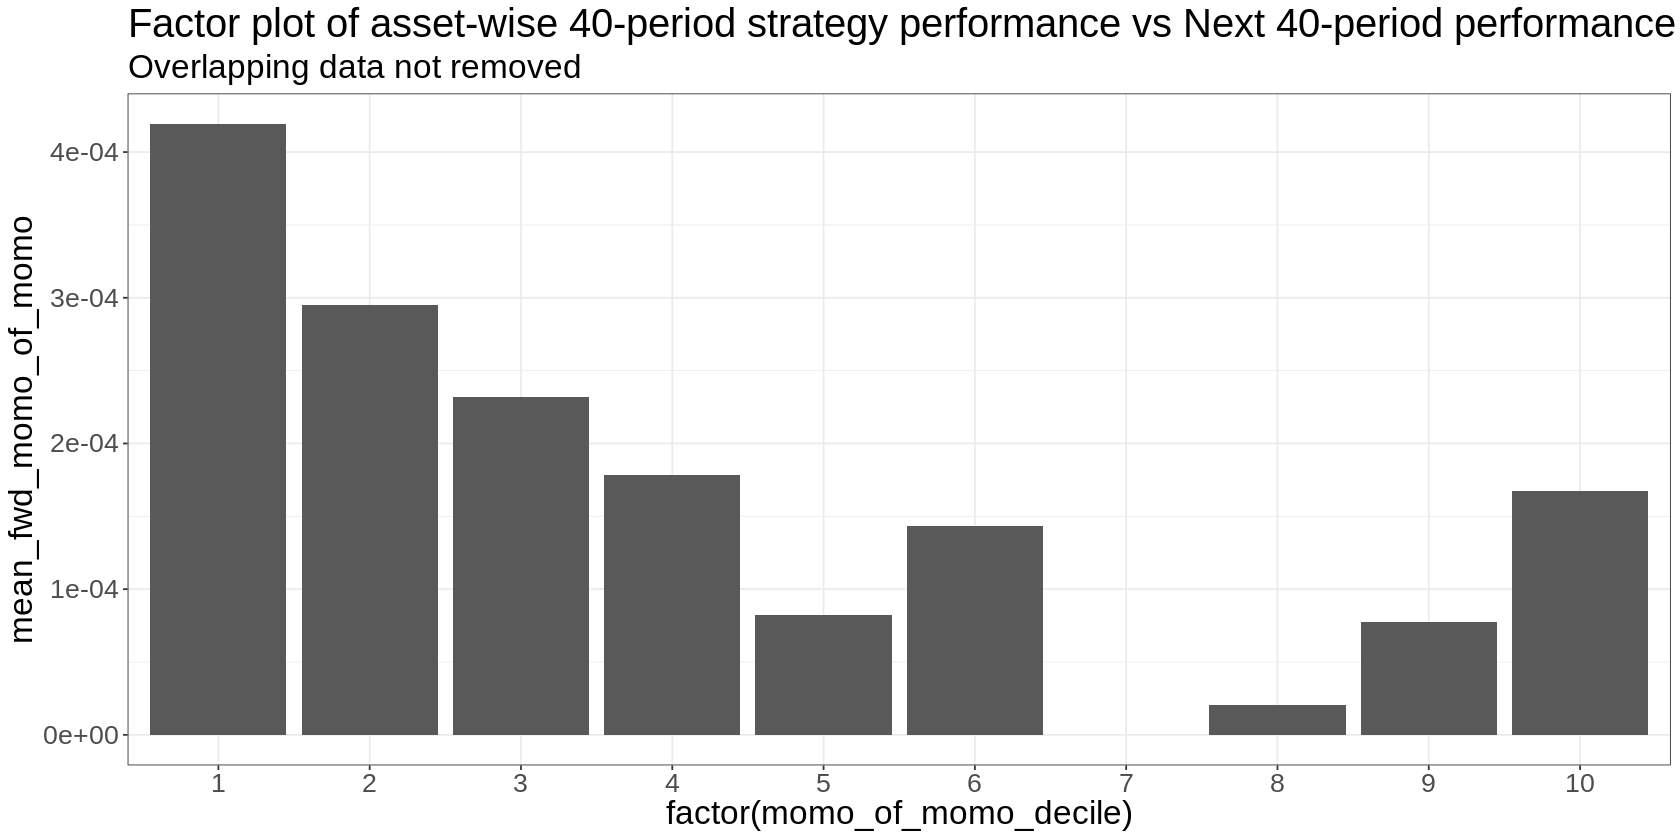

In [98]:
# don't remove overlaps this time
analysis_df <- returns_df %>%
  group_by(Ticker) %>%
  mutate(fwd_momo_of_momo = lead(momo_of_momo, 40)) %>%
  na.omit() %>%
  ungroup()

# factor plot of all the data
analysis_df %>%
  mutate(momo_of_momo_decile = ntile(momo_of_momo, 10)) %>%
  group_by(momo_of_momo_decile) %>%
  summarise(mean_fwd_momo_of_momo = mean(fwd_momo_of_momo, na.rm = TRUE)) %>%
  ggplot(aes(x = factor(momo_of_momo_decile), y = mean_fwd_momo_of_momo)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Factor plot of asset-wise 40-period strategy performance vs Next 40-period performance",
    subtitle = "Overlapping data not removed"
  )

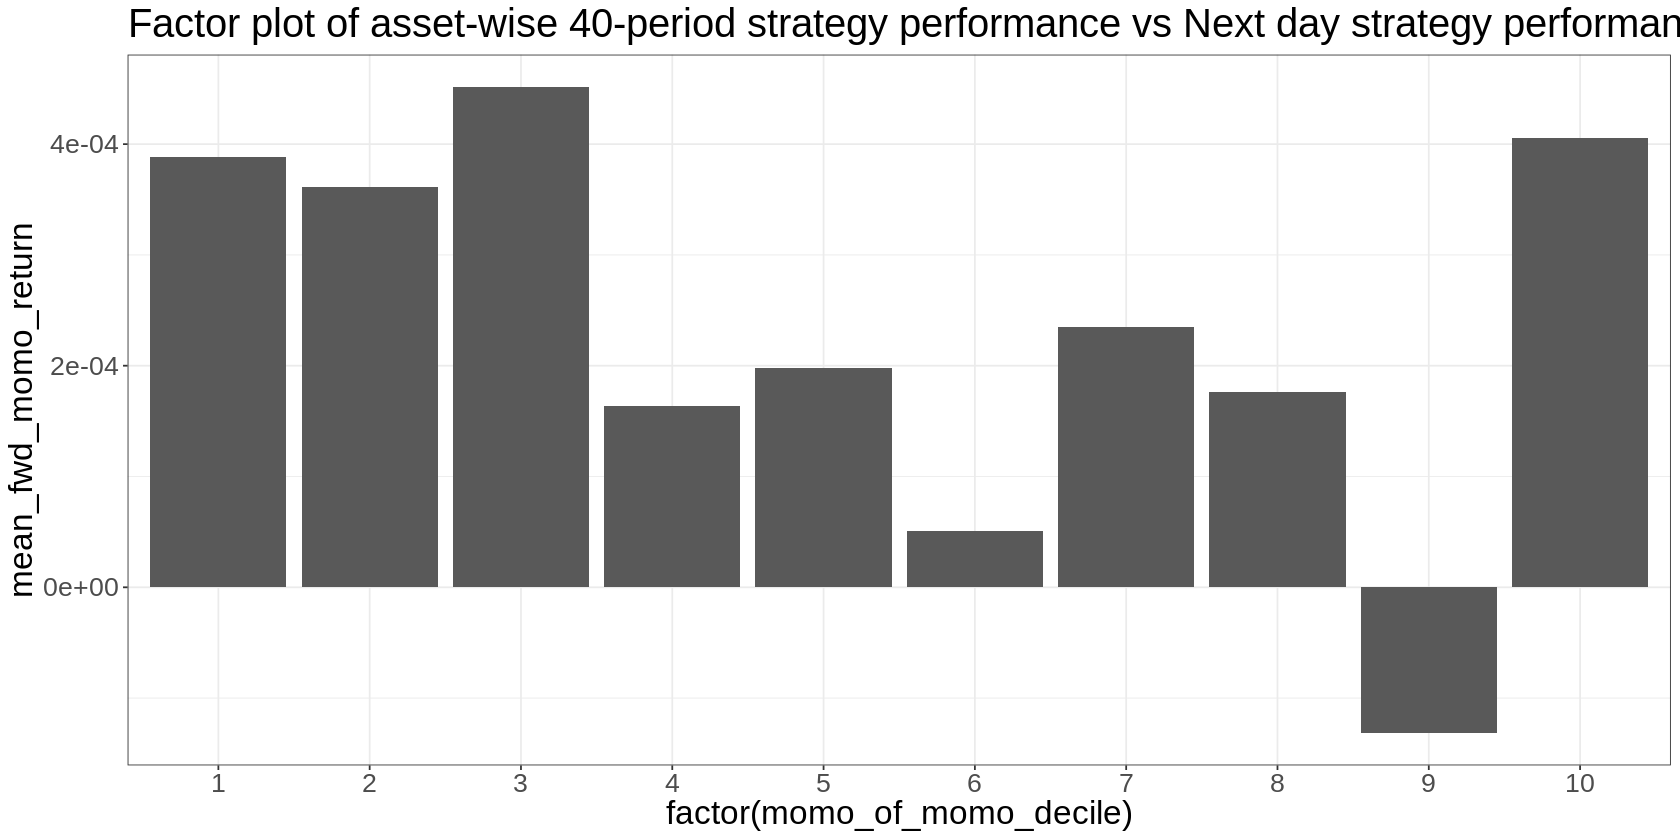

In [99]:
# how about vs next-day strategy returns
analysis_df <- returns_df %>%
  group_by(Ticker) %>%
  mutate(fwd_momo_return = lead(momo_returns, 1)) %>%
  na.omit() %>%
  ungroup()

# factor plot of all the data
analysis_df %>%
  mutate(momo_of_momo_decile = ntile(momo_of_momo, 10)) %>%
  group_by(momo_of_momo_decile) %>%
  summarise(mean_fwd_momo_return = mean(fwd_momo_return, na.rm = TRUE)) %>%
  ggplot(aes(x = factor(momo_of_momo_decile), y = mean_fwd_momo_return)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Factor plot of asset-wise 40-period strategy performance vs Next day strategy performance"
  )


Arguably a similar effect, tail pronounced.

Simple idea: scale up an asset's weight when the lagged sign of momo 40-day performance was negative, scale down when it's positive:

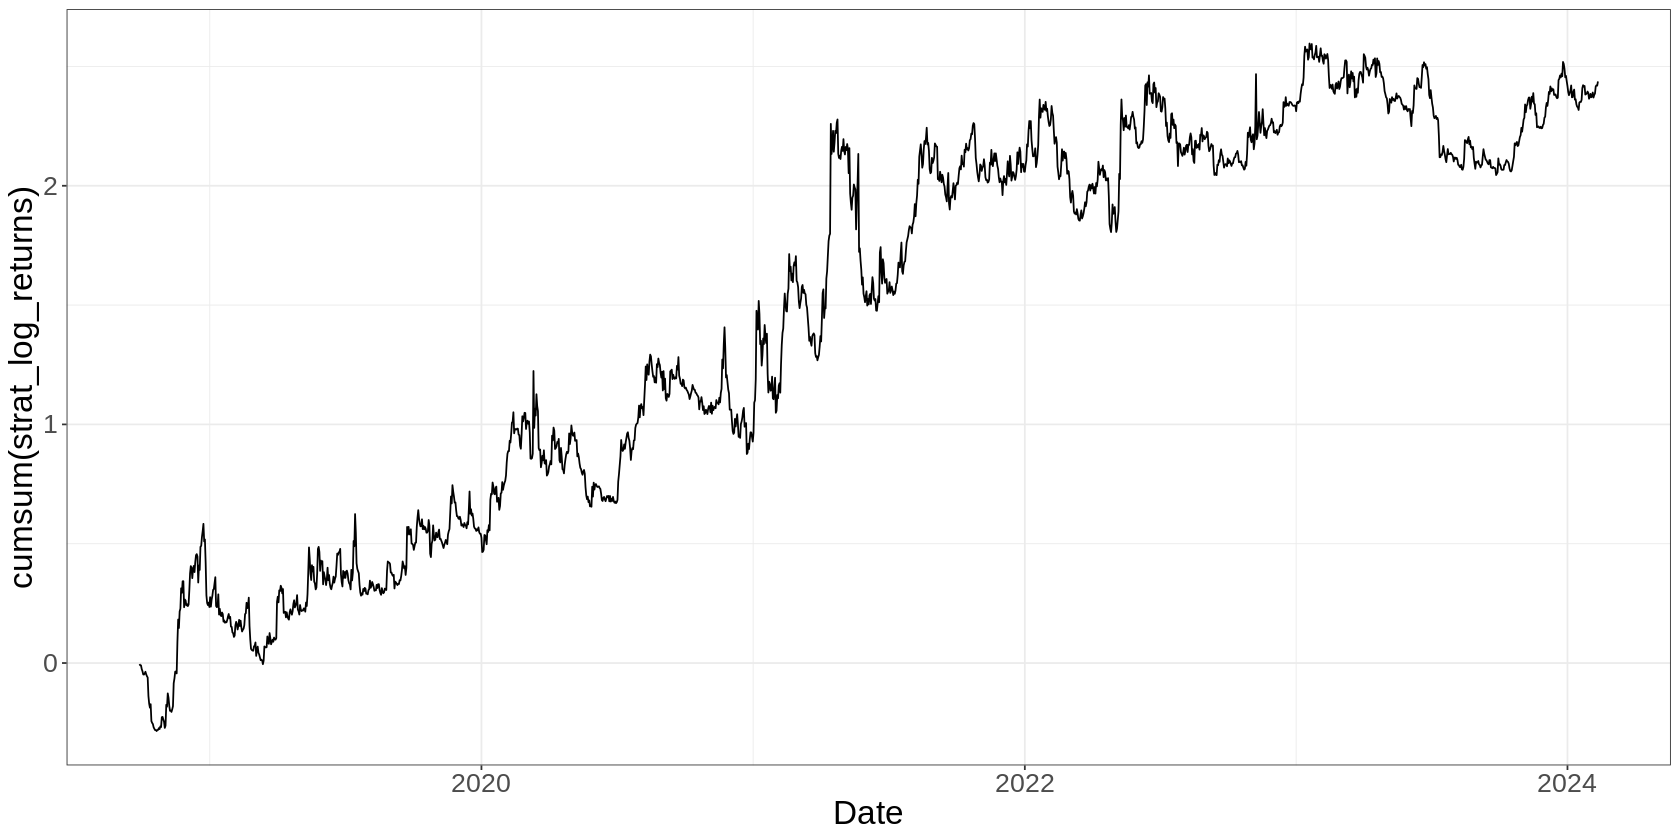

In [100]:
# Scale up when 40-day momo performance was negative
returns_df %>%
  group_by(Ticker) %>%
  mutate(momo_of_momo_sign = sign(momo_of_momo)) %>%
  mutate(lag_momo_of_momo_sign = lag(momo_of_momo_sign, 1)) %>%
  na.omit() %>%
  ungroup() %>%
  mutate(momo_of_momo_strat_weight = case_when(lag_momo_of_momo_sign < 0 ~ 2*momo_weight, TRUE ~ 0.5*momo_weight)) %>%
  group_by(Date) %>%
  mutate(scaled_momo_of_momo_strat_weight = momo_of_momo_strat_weight/sum(abs(momo_of_momo_strat_weight))) %>%
  ungroup() %>%
  mutate(strat_returns = scaled_momo_of_momo_strat_weight * fwd_return) %>%
  group_by(Date) %>%
  summarise(strat_returns = sum(strat_returns)) %>%
  mutate(strat_log_returns = log(1 + strat_returns)) %>%
  ggplot(aes(x = Date, y = cumsum(strat_log_returns))) + geom_line()

This next approach is a bit forward looking, but should be informative.

Scale by the inverse of lagged momo of momo decile - means we scale by a positive number that is bigger when momo of momo was smaller.

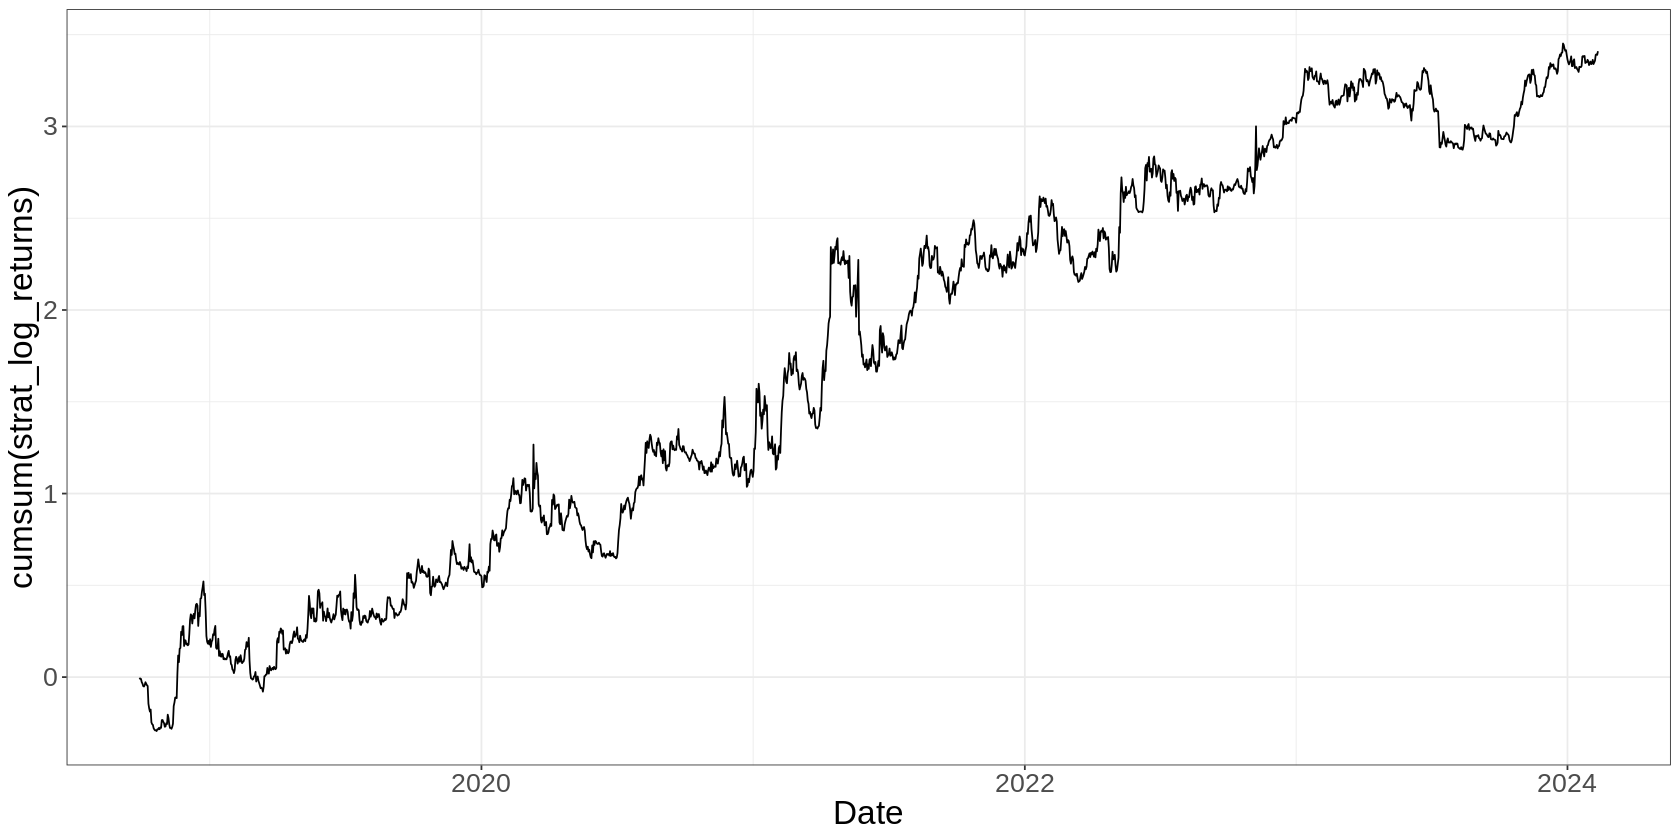

In [101]:
# scale weights by yesterday's 40-period momo returns
returns_df %>%
  group_by(Ticker) %>%
  # scale by inverse of lagged momo of momo decile - bit forward looking, but means we scale by a positive number that is bigger when momo of momo was smaller
  mutate(momo_of_momo_decile = ntile(momo_of_momo, 10)) %>%
  mutate(lag_momo_of_momo = lag(momo_of_momo_decile, 1)) %>%
  na.omit() %>%
  ungroup() %>%
  mutate(momo_of_momo_strat_weight = 1./lag_momo_of_momo * momo_weight) %>%
  group_by(Date) %>%
  mutate(scaled_momo_of_momo_strat_weight = momo_of_momo_strat_weight/sum(abs(momo_of_momo_strat_weight))) %>%
  ungroup() %>%
  mutate(strat_returns = scaled_momo_of_momo_strat_weight * fwd_return) %>%
  group_by(Date) %>%
  summarise(strat_returns = sum(strat_returns)) %>%
  mutate(strat_log_returns = log(1 + strat_returns)) %>%
  ggplot(aes(x = Date, y = cumsum(strat_log_returns))) + geom_line()